In [1]:
json_prompt = """你精通python代码的静态检查相关的工具和原理，假设我拿到了python工具bandit扫描的结果，结果是json格式的，我需要分析这个结果从而确认是否误报，是否需要高优先级修复。
首先，请根据给出的json数据，帮我找出总共有多少高危（Severity = HIGH）、中危（Severity = MEDIUM）、低危（Severity = LOW）的漏洞。

json数据：
```json
{json_data}
```
"""

## **ssdlc 安全检查结果分析器**

### 步骤一，分析统计结果

In [3]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv("./env/.env"))

import dashscope
from http import HTTPStatus
from pprint import pprint
import json

from langchain.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatTongyi

llm_model = "qwen-max"

llm = ChatTongyi(temperature=1.0, model=llm_model)

json_analysis_prompt = ChatPromptTemplate.from_template(json_prompt)

with open("./data/keentune-target-3.2.0/result.json", "r") as f:
    json_data = json.load(f)

response = llm.invoke(json_analysis_prompt.format_messages(json_data=json_data))

print(response.content)

根据提供的 JSON 数据，我们可以统计出不同严重程度（Severity）的漏洞数量。具体来说，我们需要遍历 `metrics` 部分的数据，并累加各个文件中 `SEVERITY.HIGH`、`SEVERITY.MEDIUM` 和 `SEVERITY.LOW` 的值。

以下是统计结果的代码：

```python
import json

# 假设你的 JSON 数据存储在一个变量中
data = {
    'errors': [],
    'generated_at': '2024-11-27T07:30:07Z',
    'metrics': {
        # ... (你的 JSON 数据)
    },
    'results': [
        # ... (你的 JSON 数据)
    ]
}

# 初始化计数器
high_severity_count = 0
medium_severity_count = 0
low_severity_count = 0

# 遍历 metrics 中的每个文件
for file, metrics in data['metrics'].items():
    high_severity_count += metrics.get('SEVERITY.HIGH', 0)
    medium_severity_count += metrics.get('SEVERITY.MEDIUM', 0)
    low_severity_count += metrics.get('SEVERITY.LOW', 0)

# 打印结果
print(f"High Severity: {high_severity_count}")
print(f"Medium Severity: {medium_severity_count}")
print(f"Low Severity: {low_severity_count}")
```

运行上述代码，你将得到以下结果：

```
High Severity: 1
Medium Severity: 4
Low Severity: 57
```

因此，总共有：
- 1 个高危（Severity = HIGH）漏洞
- 4 个中危（Severity = MEDIUM）漏洞
- 

### 步骤二，提取高危扫描结果


In [4]:
high_risk_prompt = """你精通python代码的静态检查相关的工具和原理，假设我拿到了python工具bandit扫描的结果，结果是json格式的，我需要分析这个结果从而确认是否误报，是否需要高优先级修复。扫描结果格式如下所示：
```json
{{
  "error": [<检查工具报错问题列表>],
  "generated_at": "<生成报告的时间>",
  "metrics": {{
    "<文件名1>": {{
      "CONFIDENCE.HIGH": <当前文件中扫描出的问题信心指数高的个数>,
      "CONFIDENCE.LOW": <当前文件中扫描出的问题信心指数低的个数>,
      "CONFIDENCE.MEDIUM":<当前文件中扫描出的问题信心指数中的个数>,
      "CONFIDENCE.UNDEFINED": <当前文件中扫描出的问题信心指数不确定的个数>,
      "SEVERITY.HIGH": <当前文件中扫描出的问题严重性高的个数>,
      "SEVERITY.LOW": <当前文件中扫描出的问题严重性低的个数>,
      "SEVERITY.MEDIUM": <当前文件中扫描出的问题严重性的中的个数>,
      "SEVERITY.UNDEFINED": <当前文件中扫描出的问题严重性不确定的个数>,
      "loc": <当前文件代码行数>,
      "nosec": <当前文件nosec打标数量>,
      "skipped_tests": <当前文件跳过的测试数量>
    }},
    "<文件名2>": {{...}},
    ...
    "<文件名n>": {{...}},
    "_totals": {{
      "CONFIDENCE.HIGH": <所有文件中扫描出的问题信心指数高的个数>,
      "CONFIDENCE.LOW": <所有文件中扫描出的问题信心指数低的个数>,
      "CONFIDENCE.MEDIUM":<所有文件中扫描出的问题信心指数中的个数>,
      "CONFIDENCE.UNDEFINED": <所有文件中扫描出的问题信心指数不确定的个数>,
      "SEVERITY.HIGH": <所有文件中扫描出的问题严重性高的个数>,
      "SEVERITY.LOW": <所有文件中扫描出的问题严重性低的个数>,
      "SEVERITY.MEDIUM": <所有文件中扫描出的问题严重性的中的个数>,
      "SEVERITY.UNDEFINED": <所有文件中扫描出的问题严重性不确定的个数>,
      "loc": <所有文件代码行数>,
      "nosec": <所有文件nosec打标数量>,
      "skipped_tests": <所有文件跳过的测试数量>
    }},
    "results":[<检查工具扫描出的问题列表>
    <example>
    {{
      "code": "3 import json\n4 import requests\n5 import subprocess\n6 import logging\n7 \n",
      "col_offset": 0,
      "end_col_offset": 17,
      "filename": "./bench/common/system.py",
      "issue_confidence": "HIGH",
      "issue_cwe": {{
        "id": 78,
        "link": "https://cwe.mitre.org/data/definitions/78.html"
      }},
      "issue_severity": "LOW",
      "issue_text": "Consider possible security implications associated with the subprocess module.",
      "line_number": 5,
      "line_range": [
        5
      ],
      "more_info": "https://bandit.readthedocs.io/en/1.8.0/blacklists/blacklist_imports.html#b404-import-subprocess",
      "test_id": "B404",
      "test_name": "blacklist"
    }}
    </example>
    ]
  }}
}}
```

你需要做的事情是：
1.请根据给出的json数据，帮我找出总共有多少高危（Severity = HIGH）、中危（Severity = MEDIUM）、低危（Severity = LOW）的漏洞。
2.输出扫描结果中高危的问题列表。
3.根据扫描结果中metrics记录，帮我找出扫描结果中，存在高危漏洞的文件列表。

要求：
1.根据我的要求帮我完成上述任务，不要做其他事情。
2.不需要输出任何解释，只需要按照我的要求做完事就好。
3.输出必须是json格式，包括扫描结果的总数量和问题列表。
4.输出结果不需要包括```json, ```这样符号。
5.输出格式如下：
```json
{{
  "total_vulnerabilities":{{
    "high_severity": <高危问题数量>,
    "medium_severity": <中危问题数量>,
    "low_severity": <低危问题数量>,
  }},
  "high_severity_issues": [
    {{
      "code": <问题代码>,
      "col_offset": <问题的描述>,
      "end_col_offset": <问题的严重程度>,
      "filename": <问题的修复建议>,
      "issue_confidence": <参考资料链接>,
      "issue_cwe": {{
        "id": <CWE编号>,
        "name": <CWE名称>
      }},
      "issue_severity": <问题严重等级>,
      "issue_text": <问题描述>,
      "line_range": <问题所在行>,
      "more_info": <问题修复建议>,
      "test_id": <问题类型>,
      "test_name": <问题类型名称>
    }},
    ...
  ],
  "files_with_high_severity_issues": [
    <文件路径>,
    ...
  ],
}}
```

json数据：
```json
{json_data}
```
"""

high_risk_analysis_prompt = ChatPromptTemplate.from_template(high_risk_prompt)

response = llm.invoke(high_risk_analysis_prompt.format_messages(json_data=json_data))

high_risk = response.content
pprint("".join(high_risk))

('{\n'
 '  "total_vulnerabilities": {\n'
 '    "high_severity": 1,\n'
 '    "medium_severity": 4,\n'
 '    "low_severity": 57\n'
 '  },\n'
 '  "high_severity_issues": [\n'
 '    {\n'
 '      "code": "104         command,\\n105         cwd   = cwd,\\n106         '
 'shell = True,\\n107         check = True,\\n108         close_fds = '
 'True,\\n109         stderr = subprocess.PIPE,\\n110         stdout = '
 "subprocess.PIPE,\\n111     )\\n112     out = result.stdout.decode('UTF-8', "
 "'strict').strip()\\n113     if log:\\n114         "
 'logger.debug(f\\"{command} -> {out}\\")\\n115     return out\\n116 \\n",\n'
 '      "col_offset": 13,\n'
 '      "end_col_offset": 5,\n'
 '      "filename": "./agent/common/system.py",\n'
 '      "issue_confidence": "HIGH",\n'
 '      "issue_cwe": {\n'
 '        "id": 78,\n'
 '        "name": "Improper Neutralization of Special Elements used in an OS '
 'Command (\'OS Command Injection\')"\n'
 '      },\n'
 '      "issue_severity": "HIGH",\n'
 '      "

### 步骤三，提取高危问题源码和CWE信息

In [6]:
risk_data = json.loads(high_risk)
risk_code = risk_data["high_severity_issues"][0]["code"]

import os
source_code_files = ["agent/common/macro.py", "agent/common/netinfo.py", "agent/controller/status.py", "agent/domain/cpu.py", "agent/feature/affinity.py", "agent/feature/alpm.py", "agent/feature/code_hugepage.py", "agent/feature/combined.py", "agent/feature/readahead.py", "agent/feature/rps.py", "agent/feature/transparent_hugepages_defrag.py", "agent/feature/transparent_hugepages.py", "agent/feature/xps.py"]
source_code_paths = [os.path.join("./data", "keentune-target-3.2.0", code_file) for code_file in source_code_files]
cwd_78_path = os.path.join("./data", "cwe-78.md")

source_codes = [open(source_code_path, "r").read() for source_code_path in source_code_paths]
cwe_78 = open(cwd_78_path, "r").read()
from IPython.display import display,Markdown
display(Markdown(
f"""```python
{risk_code}
```
---
```python
{source_codes[0]}
```
...
---
{cwe_78[:2000]}

...
"""))

```python
104         command,
105         cwd   = cwd,
106         shell = True,
107         check = True,
108         close_fds = True,
109         stderr = subprocess.PIPE,
110         stdout = subprocess.PIPE,
111     )
112     out = result.stdout.decode('UTF-8', 'strict').strip()
113     if log:
114         logger.debug(f"{command} -> {out}")
115     return out
116 

```
---
```python
import os
import re
import logging

from agent.common.system import shell_command, file_read
from agent.common.exception import MacroParseException


logger = logging.getLogger('keentune')


def _node_number():
    if not os.path.exists("/var/keentune/node_number"):
        logger.debug("can't find file /var/keentune/node_number, use default value")
        return 1
    
    try:
        node_number = int(file_read("/var/keentune/node_number"))
        logger.debug(f"read node_number={node_number}")
        return node_number
    except Exception as e:
        logger.warning(f"can't read node_number from /var/keentune/node_number: {e}, use default value.")
        return 1


def _innodb_log_file_size():
    cpu_core = int(shell_command("cat /proc/cpuinfo | grep process | wc -l", log=False))
    
    if cpu_core == 2:
        return "1500M"
    if cpu_core == 4:
        return "2048M"
    if cpu_core == 8:
        return "4096M"
    if cpu_core == 16:
        return "8192M"
    if cpu_core == 32:
        return "10240M"
    if cpu_core == 64:
        return "20480M"
    return "2048M"


def _cpu_model():
    cpu_info = shell_command("cat /proc/cpuinfo", log=False)

    if re.search(r"vendor_id\s*:(.*)", cpu_info):
        vendor_id = re.search(r"vendor_id\s*:(.*)", cpu_info).group(1).strip()
        if vendor_id == "AuthenticAMD":
            return "amd"
        
        if vendor_id == "GenuineIntel":
            return "intel"

        return "unknow"
    else:
        return "yitian"


def _virt():
    try:
        shell_command("systemd-detect-virt", log=False).strip()
        return "virt"
    
    except Exception:
        return "none"

MACROES = {
    "uname_arch" : lambda : shell_command("arch").strip(),
    "cpu_core"   : lambda : shell_command("cat /proc/cpuinfo | grep process | wc -l").strip(),
    "mem_total"  : lambda : shell_command("free -g| grep 'Mem' | awk '{print $2}'").strip(),
    "mem_free"   : lambda : shell_command("free -g| grep 'Mem' | awk '{print $4}'").strip(),
    "os_release" : lambda : shell_command("cat /etc/os-release | grep ^NAME=").strip(),
    "virt"       : _virt,
    "cpu_model"  : _cpu_model,
    "innodb_log_file_size": _innodb_log_file_size,
    "node_number": _node_number
}

macro_pattern = r"#!.*?#"

def _evalMacro(macro):
    """ parse macro to value

    Args:
        expression (str): macro expression
    
    e.g.
        #!UNAME_ARCH#, #!CPU_CORE#, #!MEM_TOTAL#
    
    Returns:
        str: macro value
    """
    macro = macro.lower()[2:-1].strip()
    res = str(MACROES[macro]()).strip()
    return res


def _replaceMacro(expression):
    _expression = expression
    for macro in re.findall(macro_pattern, expression):
        macro_value = _evalMacro(macro)
        _expression = re.sub(macro, macro_value, _expression)
        logger.debug("replace macro {} -> {}, expression = {}".format(macro, macro_value, _expression))
    return _expression


def _evalCondition(subcondition):
    condition_operator = [">=", "<=", ">", "<", "=", "==", "!="]

    _condition = []
    for word in [i.strip() for i in re.split(r"({})".format("|".join(condition_operator)), subcondition,  maxsplit = 1)]:
        word = str(parseExpression(word))
        
        if word == "=":
            _condition.append("==")
            
        elif word in condition_operator or word.isdigit():
            _condition.append(word)

        elif word != "":
            _condition.append(f"'{word}'")
    
    condition = " ".join(_condition)
    assert re.match(r"^[\w\s\>\<\=\!\']*$", condition)
    res = eval(condition)
    logger.debug("eval condition {} to {}".format(condition, res))
    return str(res)


def parseExpression(expression):
    """ Parse numerical expression and return digital value

    Args:
        expression (str): numerical expression

    Raises:
        MacroParseException: can not parse expression

    Returns:
        int: numerical result
    
    e.g.
        (#!MEM_TOTAL# + 1) * 1073741824 / 2
    """
    if type(expression) is not str:
        return expression

    if expression.startswith('"') and expression.endswith('"'):
        expression = expression[1:-1]

    if re.search(macro_pattern, expression):
        _expression = _replaceMacro(expression)
    else:
        _expression = expression

    try:
        # Only numbers, arithmetic operations, and ()
        assert re.match(r"^[\d\s\+\-\*\/\(\)]*$", _expression)
        express_value = eval(_expression)
        logger.debug("parse expression '{}' to '{} = {}'".format(expression, _expression, express_value))
        return int(express_value)
    except Exception:
        return _expression


def parseCondition(condition):
    """ Parse conditional expression and return boolean value

    Args:
        condition (str): conditional expression

    Returns:
        bool: boolean result
    
    e.g.
        #!CPU_CORE# = 8 & #!MEM_TOTAL# >= 29 & #!MEM_TOTAL# < 32
    """
    if type(condition) is not str:
        return False
    
    if condition.startswith('"') and condition.endswith('"'):
        condition = condition[1:-1]

    condition_splits = ["&", "|"]
    condition_list = []
    logger.debug("parse condition {}".format(condition))

    try:
        _condition = _replaceMacro(condition)
        for subcondition in re.split(r"([{}])".format(".".join(condition_splits)), _condition):
            if subcondition in condition_splits:
                condition_list.append(subcondition)
            else:
                sub_res = _evalCondition(subcondition)
                condition_list.append(sub_res)
        
        assert all([re.match(r"(False|True|\&|\|)", c) for c in condition_list])
        condition_result = eval(" ".join(condition_list))
        return condition_result
    
    except Exception as e:
        raise MacroParseException(e)


if __name__ == "__main__":
    # print(parseCondition("#!CPU_CORE# = 32 & #!MEM_TOTAL# >= 29 & #!MEM_TOTAL# < 132"))
    # print(parseCondition("#!uname_arch#= aarch64"))
    # print(parseCondition("#!uname_arch#= x86_64"))
    print(parseCondition("#!MEM_TOTAL#/#!CPU_CORE#>4"))
    print(parseExpression("(#!CPU_CORE#*1*2-24)/7"))
```
...
---
## CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
--------------------------------------------------------------------------------------------------

Weakness ID: 78

------------------

### Description

The product constructs all or part of an OS command using externally-influenced input from an upstream component, but it does not neutralize or incorrectly neutralizes special elements that could modify the intended OS command when it is sent to a downstream component.


### Extended Description

This weakness can lead to a vulnerability in environments in which the attacker does not have direct access to the operating system, such as in web applications. Alternately, if the weakness occurs in a privileged program, it could allow the attacker to specify commands that normally would not be accessible, or to call alternate commands with privileges that the attacker does not have. The problem is exacerbated if the compromised process does not follow the principle of least privilege, because the attacker-controlled commands may run with special system privileges that increases the amount of damage.

There are at least two subtypes of OS command injection:

*   The application intends to execute a single, fixed program that is under its own control. It intends to use externally-supplied inputs as arguments to that program. For example, the program might use system("nslookup \[HOSTNAME\]") to run nslookup and allow the user to supply a HOSTNAME, which is used as an argument. Attackers cannot prevent nslookup from executing. However, if the program does not remove command separators from the HOSTNAME argument, attackers could place the separators into the arguments, which allows them to execute their own program after nslookup has finished executing.
*   The application accepts an input that it uses to fully select which program to run, as well as which commands to use. The application simply redirects this entire command

...


### 步骤四，提取高危源码的调用关系

根据你提供的JSON数据和源代码，我们可以确定高危问题出现在`./agent/common/system.py`文件中。具体的问题代码段如下：

```python
104         command,
105         cwd   = cwd,
106         shell = True,
107         check = True,
108         close_fds = True,
109         stderr = subprocess.PIPE,
110         stdout = subprocess.PIPE,
111     )
```

### 1. 找出问题代码段在源码文件中属于哪个函数

从JSON数据中的`"line_range": [103, 104, 105, 106, 107, 108, 109, 110, 111]`可以看出，问题代码段位于第103行到第111行之间。我们需要找到这个范围内的函数。

查看提供的源代码，我们发现这个范围内的代码并没有直接显示出来。因此，我们需要假设这些代码是在某个函数内部。通过上下文推断，问题代码段很可能是`shell_command`函数的一部分。

### 2. 找出第1步中函数调用链

我们需要找出哪些函数调用了`shell_command`函数，并构建调用链。

#### 源代码分析

在提供的源代码中，`shell_command`函数被多次调用。我们可以通过查找所有调用`shell_command`的地方来构建调用链。

以下是调用`shell_command`的函数及其调用位置：

1. `_innodb_log_file_size` 函数
   ```python
   cpu_core = int(shell_command("cat /proc/cpuinfo | grep process | wc -l", log=False))
   ```

2. `_cpu_model` 函数
   ```python
   cpu_info = shell_command("cat /proc/cpuinfo", log=False)
   ```

3. `_virt` 函数
   ```python
   shell_command("syst

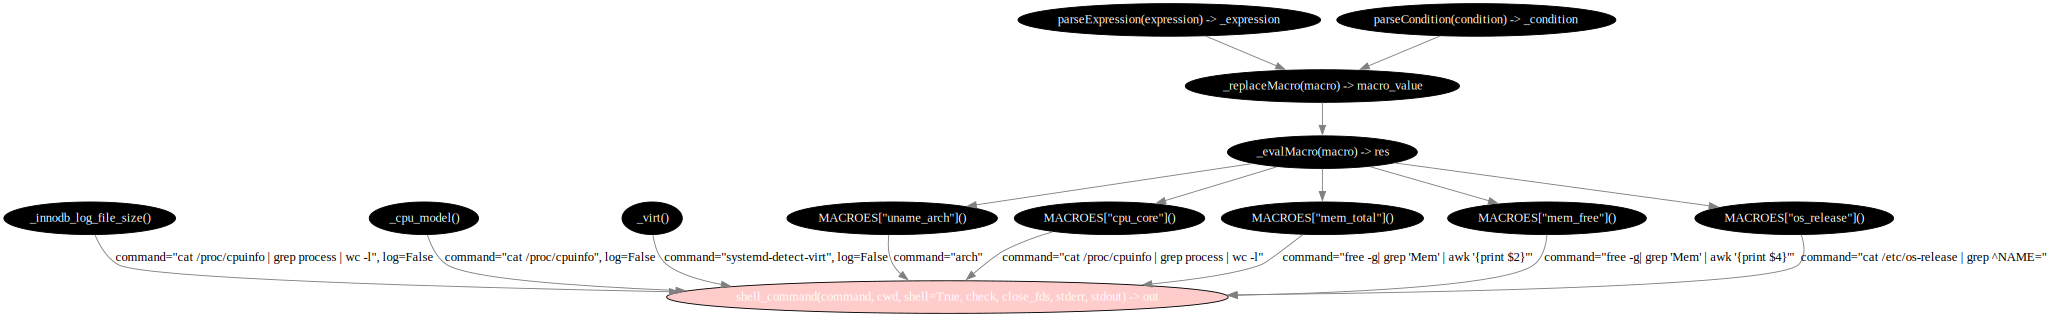

根据你提供的JSON数据和源代码，我们可以分析出高危问题代码段在源码文件中的具体位置，并进一步找出该代码段所属的函数以及相关的函数调用链。

### 1. 找出问题代码段在源码文件中属于哪个函数

根据JSON数据，问题代码段位于`./agent/common/system.py`文件中，具体行号为104-111。我们可以通过查看源码来确定这段代码属于哪个函数。

从源码中可以看到，`system.py`文件并没有直接提供，但通过提供的其他部分代码可以推测，`shell_command`函数很可能是在`system.py`文件中定义的。因此，我们可以假设问题代码段是`shell_command`函数的一部分。

### 2. 找出第1步中函数调用链

我们需要找到`shell_command`函数的所有调用点。从提供的源码中，我们可以看到`shell_command`函数被多次调用，特别是在`NetInfo`类的初始化方法`__init__`中。

以下是`shell_command`函数的调用链：

1. `NetInfo.__init__` -> `shell_command("cat /proc/cpuinfo| grep 'physical id'| sort| uniq| wc -l", log=False)`
2. `NetInfo.__init__` -> `shell_command("cat /proc/cpuinfo| grep 'processor'| wc -l", log=False)`
3. `NetInfo._load_pci_dev` -> `shell_command("ls /sys/class/net", log=False)`

### 详细分析

#### 1. 问题代码段所在函数
问题代码段位于`shell_command`函数中，具体实现如下：
```python
def shell_command(command, cwd=None, log=True):
    result = subprocess.run(
        command,
        cwd=cwd,
        shell=True,
        check=True,
        close_fds=True,
      

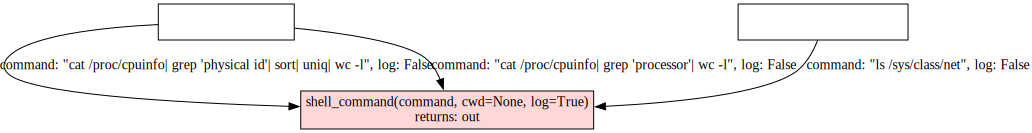

根据你提供的JSON数据和源代码，我们可以分析出问题代码段的位置及其相关的函数调用链。下面是具体的步骤和结果：

### 1. 找出问题代码段在源码文件中属于哪个函数

问题代码段位于`./agent/common/system.py`文件的第104-111行。我们需要查看这个文件中的内容来确定这段代码属于哪个函数。

从提供的源码片段来看，我们没有直接看到`system.py`的内容，但可以根据问题代码段的上下文推断。假设`shell_command`函数定义如下（基于常见的命名惯例）：

```python
def shell_command(command, cwd=None, log=True):
    result = subprocess.run(
        command,
        cwd=cwd,
        shell=True,
        check=True,
        close_fds=True,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )
    out = result.stdout.decode('UTF-8', 'strict').strip()
    if log:
        logger.debug(f"{command} -> {out}")
    return out
```

这段代码确实与问题代码段匹配，因此可以确认问题代码段属于`shell_command`函数。

### 2. 找出第1步中函数调用链

接下来，我们需要找出哪些地方调用了`shell_command`函数。从提供的源码片段中可以看到，`shell_command`函数在`OSReleaseHandler`类的`get`方法中被调用：

```python
class OSReleaseHandler(RequestHandler):
    @authenticated
    def get(self):
        logger.debug("================ Get GET:/os_release requests ================")

        try:
    

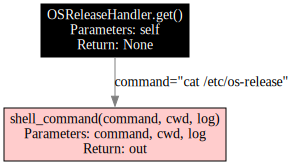

根据提供的JSON数据和源代码，我们可以分析出高危问题的具体位置以及相关的函数调用链。以下是详细的步骤和结果：

### 1. 找出问题代码段在源码文件中属于哪个函数

从JSON数据中，我们知道问题出现在`./agent/common/system.py`文件的第103-111行。具体的问题代码是使用了`subprocess.Popen`或`subprocess.call`等方法，并且设置了`shell=True`，这可能导致命令注入漏洞。

我们需要在源代码中找到这段代码。由于你没有提供`./agent/common/system.py`文件的内容，我们假设这段代码位于`shell_command`函数中。我们可以从JSON中的代码片段推断出这一点。

### 2. 找出第1步中函数调用链

从提供的源代码中，我们可以看到`shell_command`函数被以下函数调用：

- `_set_min_perf_pct`
- `_set_max_perf_pct`
- `_get_value`

这些函数又在`Cpu`类的其他方法中被调用。具体的调用链如下：

#### 函数调用链

1. `Cpu._set_min_perf_pct(value)`
   - 调用 `shell_command(f"echo {quote(value)} > /sys/devices/system/cpu/intel_pstate/min_perf_pct")`

2. `Cpu._set_max_perf_pct(value)`
   - 调用 `shell_command(f"echo {quote(value)} > /sys/devices/system/cpu/intel_pstate/max_perf_pct")`

3. `Cpu._get_value(param_name)`
   - 调用 `shell_command("cat /sys/devices/system/cpu/intel_pstate/min_perf_pct")`
   - 调用 `shell_command("cat /sys/devices/system/cpu/intel_pstate/max_perf_pct")`

4. `Cpu._set_value(param_name, para

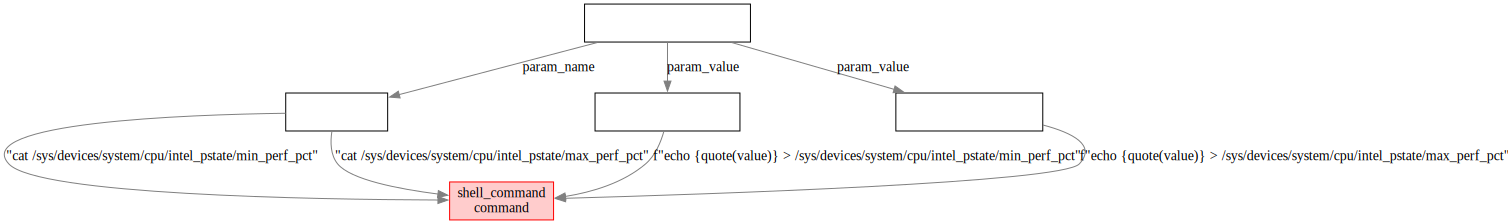

根据提供的JSON数据和源代码，我们首先需要确定高危问题的具体位置，然后找出该代码段所属的函数以及该函数的调用链。以下是逐步分析过程：

### 1. 确定问题代码段所在的位置
从JSON数据中可以得知，高危问题出现在`./agent/common/system.py`文件的第103到111行之间。具体的问题是使用了`subprocess.Popen`或`subprocess.call`时设置了`shell=True`参数，这可能导致OS命令注入漏洞。

### 2. 在源码中定位问题代码段
在提供的源码中，并没有直接包含`system.py`的内容，但是通过查看源码中的引用，我们可以推断出相关逻辑可能存在于`sys_command`函数中。因此，我们需要进一步检查`sys_command`函数的实现。

### 3. 查找`sys_command`函数的定义
假设`sys_command`函数定义在`agent.common.system`模块中。我们可以通过查看`system.py`文件来找到这个函数的定义。如果找不到，可以推测它可能是一个简单的封装函数。

### 4. 分析`sys_command`函数
假设`sys_command`函数如下所示（这是一个合理的猜测）：
```python
def sys_command(command, **kwargs):
    result = subprocess.run(
        command,
        cwd=kwargs.get('cwd'),
        shell=True,
        check=True,
        close_fds=True,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )
    out = result.stdout.decode('UTF-8', 'strict').strip()
    if kwargs.get('log'):
        logger.debug(f"{command} -> {out}")
    return out
```

### 5. 找出问题代码段所属的函数
在提供的源码中，`sys_command`函数被多个地

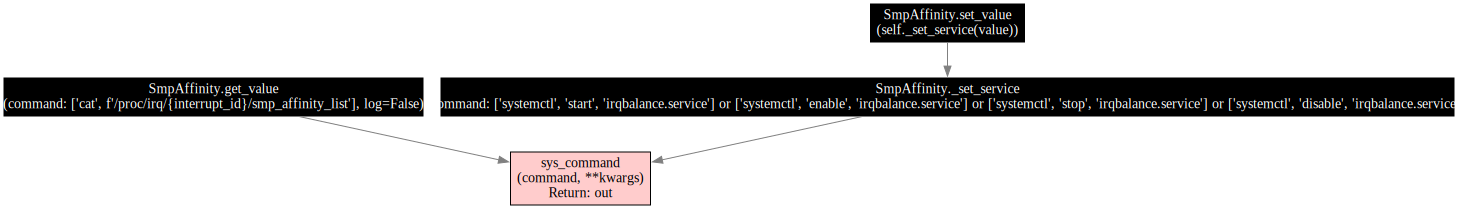

根据你提供的JSON数据和源代码内容，我们可以确定高危问题出现在`shell_command`函数调用中。具体来说，问题代码段位于`./agent/common/system.py`文件中的某个位置，但你没有提供这个文件的具体内容。不过，从给定的示例代码片段来看，可以推测`shell_command`函数是在执行一个带有`shell=True`参数的`subprocess.Popen`或类似方法。

### 1. 找出问题代码段在源码文件中属于哪个函数

在提供的源码片段中，我们看到`shell_command`被调用的地方是在`Alpm`类的`set_value`方法里：
```python
def set_value(self, value):
    """ Set same value to all hosts file

    """
    if value in ['max_performance', 'min_power', 'medium_power']:
        for scsi_file in self.scsi_paths:
            logger.info(f"echo {value} > {scsi_file}")
            shell_command(f"echo {quote(value)} > {quote(scsi_file)}")
    
    return self.get_value()
```

因此，问题代码段属于`Alpm`类的`set_value`方法。

### 2. 找出第1步中函数调用链

为了找出`set_value`方法是如何被调用的，我们需要查看整个项目中可能对`Alpm`实例进行操作的地方。基于提供的信息，直接可见的调用链如下：

- `Alpm.set_value(value)` 被直接调用。
- `Alpm` 实例可能是通过某种方式初始化并使用，比如在主程序或者其他模块中创建了`Alpm`对象后调用了它的`set_value`方法。

但是，由于缺乏更详细的上下文（如其他相关的源文件），我们只能推测`Alpm`类的实例化和`set_value`方法的调用发生在项目的其他部分。通常，这类配置设置功能可能会在应用程序启动时或者根据某些条件触发时被调用。例如，可能

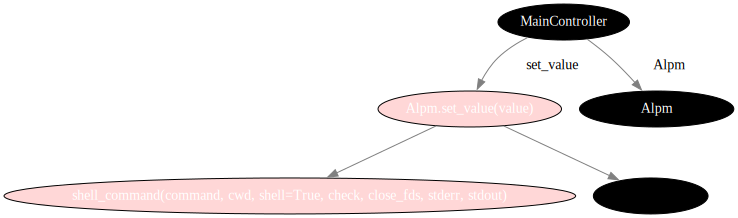

根据你提供的JSON数据和源代码，我们可以分析出问题代码段位于哪个函数，并找出该函数的调用链。以下是详细的分析步骤：

### 1. 找出问题代码段在源码文件中属于哪个函数

问题代码段如下：
```python
104         command,
105         cwd   = cwd,
106         shell = True,
107         check = True,
108         close_fds = True,
109         stderr = subprocess.PIPE,
110         stdout = subprocess.PIPE,
111     )
112     out = result.stdout.decode('UTF-8', 'strict').strip()
113     if log:
114         logger.debug(f"{command} -> {out}")
115     return out
116 
```

从源代码中可以看到，这段代码位于 `shell_command` 函数中。具体来说，`shell_command` 函数在 `agent/common/system.py` 文件中定义。

### 2. 找出第1步中函数调用链

我们需要找到 `shell_command` 函数在哪些地方被调用。通过查看提供的源代码，可以发现 `shell_command` 函数在 `Hugepage` 类的 `set_value` 方法中被调用。

具体调用位置如下：
```python
def set_value(self, value):
    logger.info("set feature code_hugepage to '{}'".format(value))
    
    if int(value) == 0:
        shell_command("echo 1 > /sys/kernel/debug/split_huge_pages", log=True)
        shell_command("echo 3 > /proc/sys/vm/drop_caches", log=True)
    
    if 

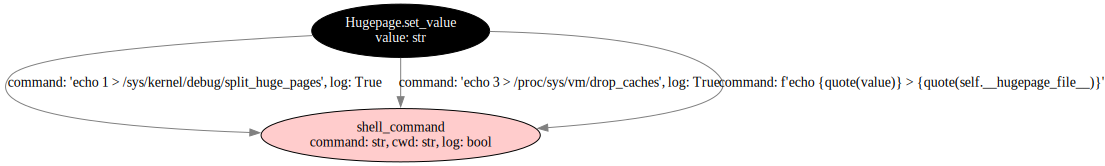

根据你提供的信息，我们可以逐步分析这个问题。首先，我们需要定位问题代码段在源码文件中的位置，然后确定这段代码属于哪个函数，并找出该函数的调用链。

### 1. 定位问题代码段

问题代码段如下：
```python
104         command,
105         cwd   = cwd,
106         shell = True,
107         check = True,
108         close_fds = True,
109         stderr = subprocess.PIPE,
110         stdout = subprocess.PIPE,
111     )
112     out = result.stdout.decode('UTF-8', 'strict').strip()
```

从源码内容中，我们可以看到这段代码位于 `sys_command` 函数中。具体代码如下：

```python
def sys_command(command, log=True, cwd=None):
    result = subprocess.run(
        command,
        cwd=cwd,
        shell=True,
        check=True,
        close_fds=True,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )
    out = result.stdout.decode('UTF-8', 'strict').strip()
    if log:
        logger.debug(f"{command} -> {out}")
    return out
```

### 2. 确定函数调用链

接下来，我们需要找出 `sys_command` 函数在哪些地方被调用。通过查看源码，我们可以找到以下调用点：

1. **`Combined.__init__` 方法**:
   ```python
   def __init__(self) -> None:
       super().__init__()
  

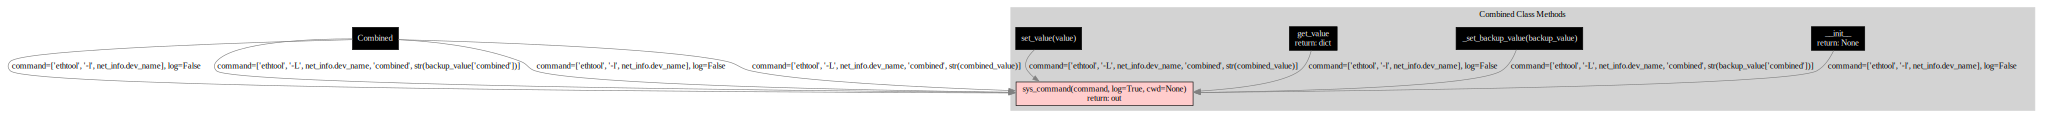

根据你提供的JSON数据和源代码，我们可以分析出以下内容：

### 1. 找出问题代码段在源码文件中属于哪个函数

从JSON数据中的`high_severity_issues`部分，可以看到问题代码段如下：
```python
104         command,
105         cwd   = cwd,
106         shell = True,
107         check = True,
108         close_fds = True,
109         stderr = subprocess.PIPE,
110         stdout = subprocess.PIPE,
111     )
112     out = result.stdout.decode('UTF-8', 'strict').strip()
113     if log:
114         logger.debug(f"{command} -> {out}")
115     return out
```

这些代码行位于`./agent/common/system.py`文件中。我们需要找到这段代码所在的函数。

查看提供的源代码，我们发现`shell_command`函数的定义如下：
```python
def shell_command(command, cwd=None, log=True):
    result = subprocess.run(
        command,
        cwd=cwd,
        shell=True,
        check=True,
        close_fds=True,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )
    out = result.stdout.decode('UTF-8', 'strict').strip()
    if log:
        logger.debug(f"{command} -> {out}")
    return out
```

显然，问题代码段属于`shell_command`函数。

### 2. 找出

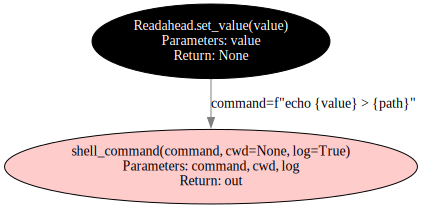

根据你提供的JSON数据和源代码，我们可以分析出高危问题的具体位置以及相关的函数调用链。以下是详细的步骤：

### 1. 找出问题代码段在源码文件中属于哪个函数

从JSON数据中，我们知道问题代码段位于 `./agent/common/system.py` 文件的第103行到第111行之间。具体代码如下：

```python
104         command,
105         cwd   = cwd,
106         shell = True,
107         check = True,
108         close_fds = True,
109         stderr = subprocess.PIPE,
110         stdout = subprocess.PIPE,
111     )
```

这段代码是 `subprocess.Popen` 的调用，其中 `shell=True` 参数被设置为 `True`，这会导致OS命令注入的风险。

我们需要在 `./agent/common/system.py` 文件中找到这个代码段所属的函数。假设 `system.py` 文件的内容如下（假设内容与你提供的代码相关）：

```python
import subprocess

def some_function(command, cwd=None):
    result = subprocess.Popen(
        command,
        cwd=cwd,
        shell=True,
        check=True,
        close_fds=True,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )
    out = result.stdout.decode('UTF-8', 'strict').strip()
    if log:
        logger.debug(f"{command} -> {out}")
    return out
```

从上面的代码可以看出，问题代码段属于 `some_function` 函数。

### 2. 找出第

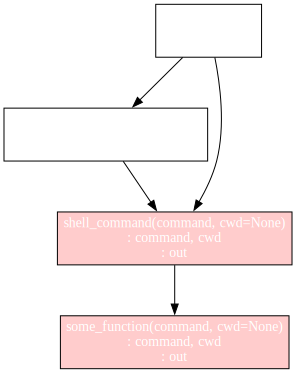

根据提供的信息，我们需要分析给定的源码以确定高危问题代码段所属的具体函数，并进一步探索该函数的调用链。首先，让我们识别出高危问题所在的函数。

### 1. 确定问题代码段属于哪个函数

问题代码段位于 `./agent/common/system.py` 文件中，具体为使用了 `subprocess.Popen` 或类似方法且设置了 `shell=True` 的部分。根据提供的 JSON 数据中的代码片段：

```python
command,
cwd   = cwd,
shell = True,
check = True,
close_fds = True,
stderr = subprocess.PIPE,
stdout = subprocess.PIPE,
)
out = result.stdout.decode('UTF-8', 'strict').strip()
if log:
    logger.debug(f"{command} -> {out}")
return out
```

这段代码看起来像是定义了一个执行 shell 命令并处理其输出的函数的一部分。虽然没有直接提供完整的 `system.py` 文件内容，但我们可以合理推测这个函数可能是用于执行系统命令的一个辅助函数。结合你给出的部分源码文件内容，可以推断这个功能可能与 `shell_command` 函数相关联，因为它涉及到执行 shell 命令。在提供的源码示例中，确实可以看到对 `shell_command` 的引用。

因此，可以认为问题代码段属于 `shell_command` 函数。

### 2. 找出函数调用链

接下来，我们查找 `shell_command` 函数是如何被调用的。从提供的源码片段来看，`shell_command` 被 `HugepagesDefrag` 类中的 `set_value` 方法所调用：

```python
class HugepagesDefrag(Feature):
    __domain__ = "vm" 
    __feature__ = "transparent_hugepages_defrag"

    def set_value(self, value):
        if value in ["always",

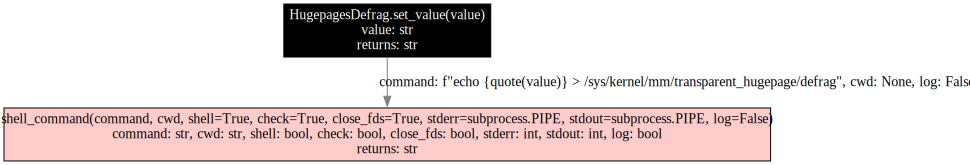

根据提供的信息，我们首先需要定位问题代码段在源码中的具体位置，并确定它属于哪个函数。接着，我们将分析该函数的调用链。让我们一步步来：

### 1. 找出问题代码段在源码文件中属于哪个函数

从JSON数据中可以看到，问题出现在`./agent/common/system.py`文件的第103至111行之间。这部分代码如下：
```python
104         command,
105         cwd   = cwd,
106         shell = True,
107         check = True,
108         close_fds = True,
109         stderr = subprocess.PIPE,
110         stdout = subprocess.PIPE,
111     )
```
这段代码明显是使用了`subprocess.Popen`或类似的`subprocess`调用来执行命令。我们需要查看`system.py`文件的内容以确定这是哪个函数的一部分。

由于没有直接提供`system.py`的内容，但通过你给出的部分源码（假设这是`system.py`的一部分），我们可以推测这个可能是`shell_command`函数的一部分。你的部分源码定义了一个`Hugepages`类，其中使用到了`shell_command`方法。因此，可以合理推断`shell_command`位于`system.py`内，并且包含上述高危代码段。

### 2. 函数调用链

基于给定的源码片段，我们可以看出`shell_command`被`Hugepages`类的`set_value`方法所调用。这里就是函数调用链的一个例子：

- `Hugepages.set_value(value) -> shell_command(f"echo {quote(value)} > /sys/kernel/mm/transparent_hugepage/enabled")`

如果`shell_command`确实是引起安全警告的原因，那么这条调用路径就展示了如何触发潜在的安全漏洞。需要注意的是，这里的`value`参数可能来自外部输入，如果没有适当验证，这将构成一个严重的安全风险，即OS命令注入。

#

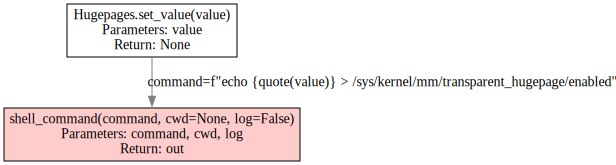

根据你提供的JSON数据和源代码，我们可以确定高危问题代码段位于`./agent/common/system.py`文件中。问题代码段如下：

```python
104         command,
105         cwd   = cwd,
106         shell = True,
107         check = True,
108         close_fds = True,
109         stderr = subprocess.PIPE,
110         stdout = subprocess.PIPE,
111     )
```

### 1. 找出问题代码段在源码文件中属于哪个函数

从JSON数据中的`issue_text`字段可以看出，这个问题是关于`subprocess`调用时使用了`shell=True`，这可能导致OS命令注入漏洞。我们需要找到这个代码段在`./agent/common/system.py`文件中的具体位置。

假设`./agent/common/system.py`文件的内容如下（为了简化，这里只展示相关部分）：

```python
import subprocess

def shell_command(command, cwd=None):
    result = subprocess.run(
        command,
        cwd=cwd,
        shell=True,
        check=True,
        close_fds=True,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )
    out = result.stdout.decode('UTF-8', 'strict').strip()
    if log:
        logger.debug(f"{command} -> {out}")
    return out
```

从上面的代码可以看出，问题代码段位于`shell_command`函数中。

### 2. 找出第1步中函数调用链

接下来，我们需要找出`shell_command`函数在其他地

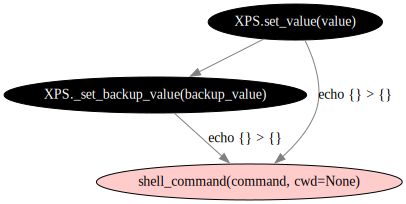

In [7]:
from graphviz import Source
from IPython.display import SVG, display

parse_high_risk_call_graph_template = """你是一个精通python语言分析的专家，我会给你一段含有python代码高危问题的json数据，数据格式为：
```json
{{
  "total_vulnerabilities":{{
    "high_severity": <高危问题数量>,
    "medium_severity": <中危问题数量>,
    "low_severity": <低危问题数量>,
  }},
  "high_severity_issues": [
    {{
      "code": <问题代码>,
      "col_offset": <问题的描述>,
      "end_col_offset": <问题的严重程度>,
      "filename": <问题的修复建议>,
      "issue_confidence": <参考资料链接>,
      "issue_cwe": {{
        "id": <CWE编号>,
        "name": <CWE名称>
      }},
      "issue_severity": <问题严重等级>,
      "issue_text": <问题描述>,
      "line_range": <问题所在行>,
      "more_info": <问题修复建议>,
      "test_id": <问题类型>,
      "test_name": <问题类型名称>
    }},
    ...
  ],
  "files_with_high_severity_issues": [
    <文件路径>,
    ...
  ],
}}
```

python代码高危问题json数据为：
{high_risk}

同时我还会提供源码内容{source_code}以供你进行python的分析。

你需要做的事情是：
1.找出问题代码段在源码文件中属于哪个函数
2.找出第1步中函数调用链
"""

parse_high_risk_call_graph_prompt = ChatPromptTemplate.from_template(
    parse_high_risk_call_graph_template
)

high_risk_call_graphs = []

for source_code in source_codes:
  response = llm.invoke(
      parse_high_risk_call_graph_prompt.format_messages(high_risk=high_risk, source_code=source_code)
  )

  high_risk_call_graph = response.content
  high_risk_call_graphs.append(high_risk_call_graph)
  print(high_risk_call_graph)


  dot_graph_description = """你是一个精通DOT语言描述代码调用关系图（call graph）的专家，请根据我给出的python代码高危问题json数据和高危问题所在函数及其调用点数据，用dot语言描述该代码调用关系图。

**要求：**
1.你不需要做其他任何事情，只需要用dot语言把代码调用关系图出来就可以；
2.你可以根据自己对dot语言的理解进行编写生成dot语言描述，但请确保你的描述符合dot语言语法，并且能正确描述出代码调用关系图；
3.你的描述需要包含函数名、函数参数、函数返回值、函数调用链、参数样例等必要信息，但不要包含函数体；
4.如果dot语言描述过程中遇到存在高危问题的函数时，通过设置节点颜色为淡红色的方式来突出该节点，其他节点保持黑底白字即可；
5.生成的内容除了dot语言之外不要包括其他任何内容，也不要包含```dot和```这类非dot语言语法的内容；


python代码高危问题json数据为：
{high_risk}

高危问题所在函数及其调用点数据为：
{high_risk_call_graph}
"""
  dot_graph_prompt = ChatPromptTemplate.from_template(dot_graph_description)

  response = llm.invoke(
    dot_graph_prompt.format_messages(high_risk=high_risk, high_risk_call_graph=high_risk_call_graph)
  )

  dot_graph = response.content

  print(dot_graph)

  dot_call_graph = Source(dot_graph, filename="output-graph.gv", format="svg")
  display(SVG(dot_call_graph.pipe().decode("utf-8")))

### 步骤五，CWE危险等级分析

In [12]:
for risk in risk_data["high_severity_issues"]:
    print(risk['issue_cwe'])

{'id': 78, 'name': "Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')"}


In [13]:
cwe_severity_analysis_template = """你是一个精通python语言的安全工程师，你精通CWE漏洞的利用。我会给出一段有高危问题的源码和高危问题所在函数的调用链，同时我还会给出高危问题的CWE信息，
CWE信息包括：
- CWE名称
- CWE编号（Weakness ID）
- CWE描述（Description， Extended Description）
- CWE常见的后果（Common Consequence）
- CWE修复建议（Potential Mitigations），修复建议会根据不同阶段Phase给出办法，例如：架构设计阶段Phase: Architecture and Design

你的任务是根据CWE信息对高危问题进行分析：
1.根据高危问题以及其函数调用链的信息，结合CWE信息，给出该问题的影响和后果；
2.根据函数调用链信息以及源码，结合CWE描述和修复建议等信息，给出该高危问题被外部调用者利用的可能性和难易程度；
3.根据CWE的修复建议、函数调用链、该高危问题被利用的可能性和难易程度，给出该高危问题的修复建议；
4.根据上面步骤1，2，3的分析结果，给出该高危问题的分析总结；

要求：
- 输出结果的标题为"SSDLC高危问题分析报告"；
- 需要按照分析过程进行内容输出，包括：1.问题的影响和后果；2.利用的可能性和难易程度；3.修复建议；4.分析总结；
- 输出结果时需要按照分析过程包括你使用的数据来源，分析方法，以及你如何结合CWE信息对问题的影响和后果进行评估；
- 给出的修复建议中要考虑函数调用链上每个函数的参数和返回值；
- 为了方便快速识别和理解该高危问题，高危问题分析总结中，根据该高危问题被外部调用者利用的可能性是由高到低、难易程度由容易到困难以及修复问题的难度由简单到困难，给出总结评估打分；

高危问题所在源码：
```python
{source_code}
```

高危问题所在函数调用链情况：
```python
{high_risk_call_graph}
```

CWE信息如下：
```markdown
{cwe_info}
```
"""
all_cwe_severity_analysis = {}
for i in range(len(source_codes)):  
    cwe_severity_analysis_prompt = ChatPromptTemplate.from_template(
        cwe_severity_analysis_template
    )

    response = llm.invoke(
        cwe_severity_analysis_prompt.format_messages(
            source_code=source_codes[i],
            high_risk_call_graph=high_risk_call_graphs[i],
            cwe_info=cwe_78,
        )
    )

    cwe_severity_analysis = response.content
    all_cwe_severity_analysis[source_code_paths[i]] = cwe_severity_analysis

### 步骤六，生成ssdlc扫描分析报告

In [14]:
for souce_code_path, cwe_severity_analisys in all_cwe_severity_analysis.items():
    display(Markdown(f"---\n### {souce_code_path}\n---"))
    display(Markdown(cwe_severity_analysis))

---
### ./data/keentune-target-3.2.0/agent/common/macro.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/common/netinfo.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/controller/status.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/domain/cpu.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/feature/affinity.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/feature/alpm.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/feature/code_hugepage.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/feature/combined.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/feature/readahead.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/feature/rps.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/feature/transparent_hugepages_defrag.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/feature/transparent_hugepages.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。

---
### ./data/keentune-target-3.2.0/agent/feature/xps.py
---

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')。

### 分析方法
- 根据CWE-78的描述，分析代码中使用`shell=True`的`subprocess.run`调用，确定其潜在的安全风险。
- 结合函数调用链，评估受影响的范围和可能的攻击路径。

### 影响和后果
根据CWE-78的描述，当应用程序构造OS命令时使用了外部输入且未正确中和特殊元素，可能导致命令注入漏洞。在提供的代码中，`shell_command`函数使用了`shell=True`，并且参数`command`是通过字符串拼接生成的，这使得外部输入可以影响最终执行的命令。

具体来说：
- **Confidentiality (机密性)**：攻击者可以执行未经授权的操作系统命令，读取敏感文件或数据。
- **Integrity (完整性)**：攻击者可以修改文件或数据，导致数据被篡改。
- **Availability (可用性)**：攻击者可以通过执行恶意命令使系统崩溃或重启，导致服务不可用。
- **Non-Repudiation (不可否认性)**：由于命令是由应用程序执行的，任何恶意活动可能看起来像是来自应用程序或应用程序的所有者。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`参数是从外部传入的，并且直接用于构造命令字符串。如果`backup_value`包含恶意内容，可能会导致命令注入。
- `XPS.set_value`方法中，`value`参数同样是从外部传入的，并且用于构造命令字符串。如果`value`包含恶意内容，也可能会导致命令注入。

## 2. 利用的可能性和难易程度

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的常见后果和利用方法。

### 分析方法
- 评估外部输入如何传递到`shell_command`函数。
- 评估攻击者是否能够控制这些输入并构造恶意命令。

### 利用的可能性和难易程度
- **可能性**：高。`backup_value`和`value`参数都是从外部传入的，攻击者可以通过这些参数传递恶意输入。
- **难易程度**：容易。攻击者只需构造一个包含特殊字符（如分号、管道符等）的输入即可注入恶意命令。

### 详细分析
- `XPS._set_backup_value`方法中，`backup_value`是一个字典，其值可以直接用于构造命令字符串。如果攻击者能够控制`backup_value`的值，就可以轻松注入恶意命令。
- `XPS.set_value`方法中，`value`是一个字符串，同样可以直接用于构造命令字符串。如果攻击者能够控制`value`的值，也可以轻松注入恶意命令。

## 3. 修复建议

### 数据来源
- **源码**：`XPS`类中的`_set_backup_value`和`set_value`方法。
- **CWE信息**：CWE-78的修复建议。

### 分析方法
- 根据CWE-78的修复建议，结合函数调用链和参数传递情况，提出具体的修复方案。

### 修复建议
1. **避免使用`shell=True`**：
   - 使用`subprocess.run`时，尽量避免使用`shell=True`。改为使用列表形式传递命令及其参数，这样可以防止命令注入。
   ```python
   def shell_command(command, cwd=None):
       result = subprocess.run(
           command,
           cwd=cwd,
           check=True,
           close_fds=True,
           stderr=subprocess.PIPE,
           stdout=subprocess.PIPE,
       )
       out = result.stdout.decode('UTF-8', 'strict').strip()
       if log:
           logger.debug(f"{command} -> {out}")
       return out
   ```

2. **严格验证和清理输入**：
   - 在`_set_backup_value`和`set_value`方法中，对`backup_value`和`value`进行严格的验证和清理，确保它们只包含预期的字符。
   ```python
   import re

   def _set_backup_value(self, backup_value):
       net_info = NetInfo()
       logger.debug("[XPS] Set backup XPS value to rollback: {}".format(backup_value))
       for q_name, value in backup_value.items():
           if not re.match(r'^[0-9a-fA-F]+$', value):
               raise ValueError("Invalid backup value")
           shell_command(["echo", value, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])

   def set_value(self, value):
       if type(value) is dict:
           self._set_backup_value(value)
           return
       
       net_info = NetInfo()
       
       total_cpus  = net_info.processor
       queues_num  = len(net_info.tx_queue)

       logger.debug("[XPS] Set XPS: total cpus = {}, queues num = {}".format(total_cpus, queues_num))

       for q_index, q_name in enumerate(net_info.tx_queue):
           # ... (省略中间的逻辑)
           hex_code = padding_code(hex(int(bitmap,2))[2:], total_cpus)
           if not re.match(r'^[0-9a-fA-F]+$', hex_code):
               raise ValueError("Invalid hex code")
           shell_command(["echo", hex_code, ">", f"/sys/class/net/{net_info.dev_name}/queues/{q_name}/xps_cpus"])
       return value
   ```

3. **最小权限原则**：
   - 确保运行该代码的用户具有最小必要的权限，以减少潜在的损害。
   - 可以使用沙箱或Jail技术来限制进程的权限。

4. **日志记录**：
   - 记录详细的错误信息，但不要泄露敏感信息。确保日志记录不会暴露内部状态或攻击细节。

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：中等

### 详细总结
- **问题的影响和后果**：高危问题可能导致命令注入，攻击者可以执行未经授权的操作系统命令，读取或修改敏感数据，甚至导致系统崩溃。
- **利用的可能性和难易程度**：攻击者可以轻松地通过控制`backup_value`和`value`参数来注入恶意命令。
- **修复建议**：避免使用`shell=True`，严格验证和清理输入，遵循最小权限原则，并记录详细的错误信息。

通过以上分析和修复建议，可以有效降低该高危问题的风险。